In [123]:
library(dplyr)
library(readr)
library(ggplot2)
library(itertools)
library(rlist)

In [124]:
energy      <- "electricity"
hourlyPath  <- paste0("../../curated/", energy, "/gold_hourly_",     energy, ".csv")
dailyPath   <- paste0("../../curated/", energy, "/gold_daily_",      energy, ".csv")
monthlyPath <- paste0("../../curated/", energy, "/gold_monthly_",    energy, ".csv")


In [125]:
# Hourly
energyHourly    <-  read_csv(hourlyPath, show_col_types = FALSE)
weatherHourly   <-  read_csv("../../curated/weather/gold_hourly_weather.csv", show_col_types = FALSE)

# Daily
energyDaily     <-  read_csv(dailyPath, show_col_types = FALSE)
weatherDaily    <-  read_csv("../../curated/weather/gold_daily_weather.csv", show_col_types = FALSE)

# Monthly
energyMonthly   <-  read_csv(monthlyPath, show_col_types = FALSE) %>%
                    mutate(year_month = factor(paste(year, month, sep = "-")))
weatherMonthly  <-  read_csv("../../curated/weather/gold_monthly_weather.csv", show_col_types = FALSE) %>%
                    mutate(year_month = factor(paste(year, month, sep = "-")))

In [126]:
dfHourly <- weatherHourly %>%
    left_join(energyHourly,   by = c("year", "month", "hour"), suffix = c("", "_energy")) %>%
    select(
        year, 
        month, 
        hour,
        avg_temp, avg_dewpt_temp,
        avg_rel_hum_pct,
        avg_wind_dir,
        avg_wind_spd,
        avg_visib,
        avg_stn_press,
        avg_hmdx,
        avg_wind_chill,
        consumption
    )

dfDaily <- weatherDaily %>%
    left_join(energyDaily,   by = c("year", "month", "day", "date"), suffix = c("", "_energy")) %>%
    select(
        year, 
        month,
        date,
        day,
        avg_temp,
        avg_dewpt_temp,
        avg_rel_hum_pct,
        avg_wind_dir,
        avg_wind_spd,
        avg_visib,
        avg_stn_press,
        avg_hmdx,
        avg_wind_chill,
        consumption
    )

dfMonthly <- weatherMonthly %>%
    left_join(energyMonthly,   by = c("year", "month"), suffix = c("", "_energy")) %>%
    select(
        year, 
        month,
        year_month,
        avg_temp,
        avg_dewpt_temp,
        avg_rel_hum_pct,
        avg_wind_dir,
        avg_wind_spd,
        avg_visib,
        avg_stn_press,
        avg_hmdx,
        avg_wind_chill,
        consumption
    )

# Correlations

In [140]:
mat <- matrix(data = NA, nrow = 10, ncol = 10)
cols <- colnames(dfMonthly)
cols <- cols[!(cols %in% c("year", "month", "year_month"))]

for(col1 in as.list(enumerate(cols))) {
    for(col2 in as.list(enumerate(cols))){
        myCor <- cor(dfMonthly[col1$value], dfMonthly[col2$value])
        mat[col1$index, col2$index] <- myCor
    }
}
df <- as.data.frame(mat, row.names = cols)
colnames(df) <- cols

df

,avg_temp,avg_dewpt_temp,avg_rel_hum_pct,avg_wind_dir,avg_wind_spd,avg_visib,avg_stn_press,avg_hmdx,avg_wind_chill,consumption
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
avg_temp,1.00000000,0.9612256,-0.57812261,0.61332053,-0.03499943,0.8332301,-0.37023814,0.60729146,0.35561567,-0.7485483
avg_dewpt_temp,0.96122560,1.0000000,-0.33153291,0.56618256,-0.15373840,0.7117861,-0.37786440,0.60228328,0.43264625,-0.6487659
avg_rel_hum_pct,-0.57812261,-0.3315329,1.00000000,-0.42764826,-0.36170244,-0.7476164,0.15724993,-0.28497871,0.04362704,0.6255543
avg_wind_dir,0.61332053,0.5661826,-0.42764826,1.00000000,-0.04094928,0.7294032,-0.03299416,0.31543055,0.36650973,-0.5059482
avg_wind_spd,-0.03499943,-0.1537384,-0.36170244,-0.04094928,1.00000000,0.1081804,-0.51351223,-0.03386936,-0.12416074,0.0807484
avg_visib,0.83323007,0.7117861,-0.74761639,0.72940317,0.10818041,1.0000000,-0.14907113,0.54415175,0.13566132,-0.7191936
avg_stn_press,-0.37023814,-0.3778644,0.15724993,-0.03299416,-0.51351223,-0.1490711,1.00000000,-0.18090134,-0.17207546,0.2626833
avg_hmdx,0.60729146,0.6022833,-0.28497871,0.31543055,-0.03386936,0.5441518,-0.18090134,1.00000000,0.09303448,-0.3382928
avg_wind_chill,0.35561567,0.4326462,0.04362704,0.36650973,-0.12416074,0.1356613,-0.17207546,0.09303448,1.00000000,0.1420389


# Machine Learning Model: Linear Regression

In [136]:
mdl_hr <-   lm(consumption ~ avg_temp * avg_dewpt_temp * avg_rel_hum_pct * avg_hmdx, data = dfHourly)
mdl_d <-    lm(consumption ~ avg_temp * avg_dewpt_temp * avg_rel_hum_pct * avg_hmdx, data = dfDaily)
mdl_m <-    lm(consumption ~ avg_temp * avg_dewpt_temp * avg_rel_hum_pct * avg_hmdx, data = dfMonthly)

# mdl_hr <-   lm(consumption ~ avg_temp * avg_dewpt_temp, data = dfHourly)
# mdl_d <-    lm(consumption ~ avg_temp * avg_dewpt_temp, data = dfDaily)
# mdl_m <-    lm(consumption ~ avg_temp * avg_dewpt_temp, data = dfMonthly)

In [137]:
mdl_stats <- data.frame(
    Models = c("Hourly", "Daily", "Monthly"),
    `R2` = c(
        summary(mdl_hr)$r.squared,
        summary(mdl_d)$r.squared,
        summary(mdl_m)$r.squared
    ),
    `Adj_R2` = c(
        summary(mdl_hr)$adj.r.squared,
        summary(mdl_d)$adj.r.squared,
        summary(mdl_m)$adj.r.squared
    )
)

mdl_stats

Models,R2,Adj_R2
<chr>,<dbl>,<dbl>
Hourly,0.03338753,0.03336032
Daily,0.32677479,0.31263140
Monthly,0.92541361,0.82845130


# Validation of linear regression model

In [138]:
dfMonthly_pred <- dfMonthly %>%
    mutate(
        pred = predict(mdl_m),
        diff = round(pred - consumption, digits = 2)
    )

`geom_smooth()` using formula = 'y ~ x'


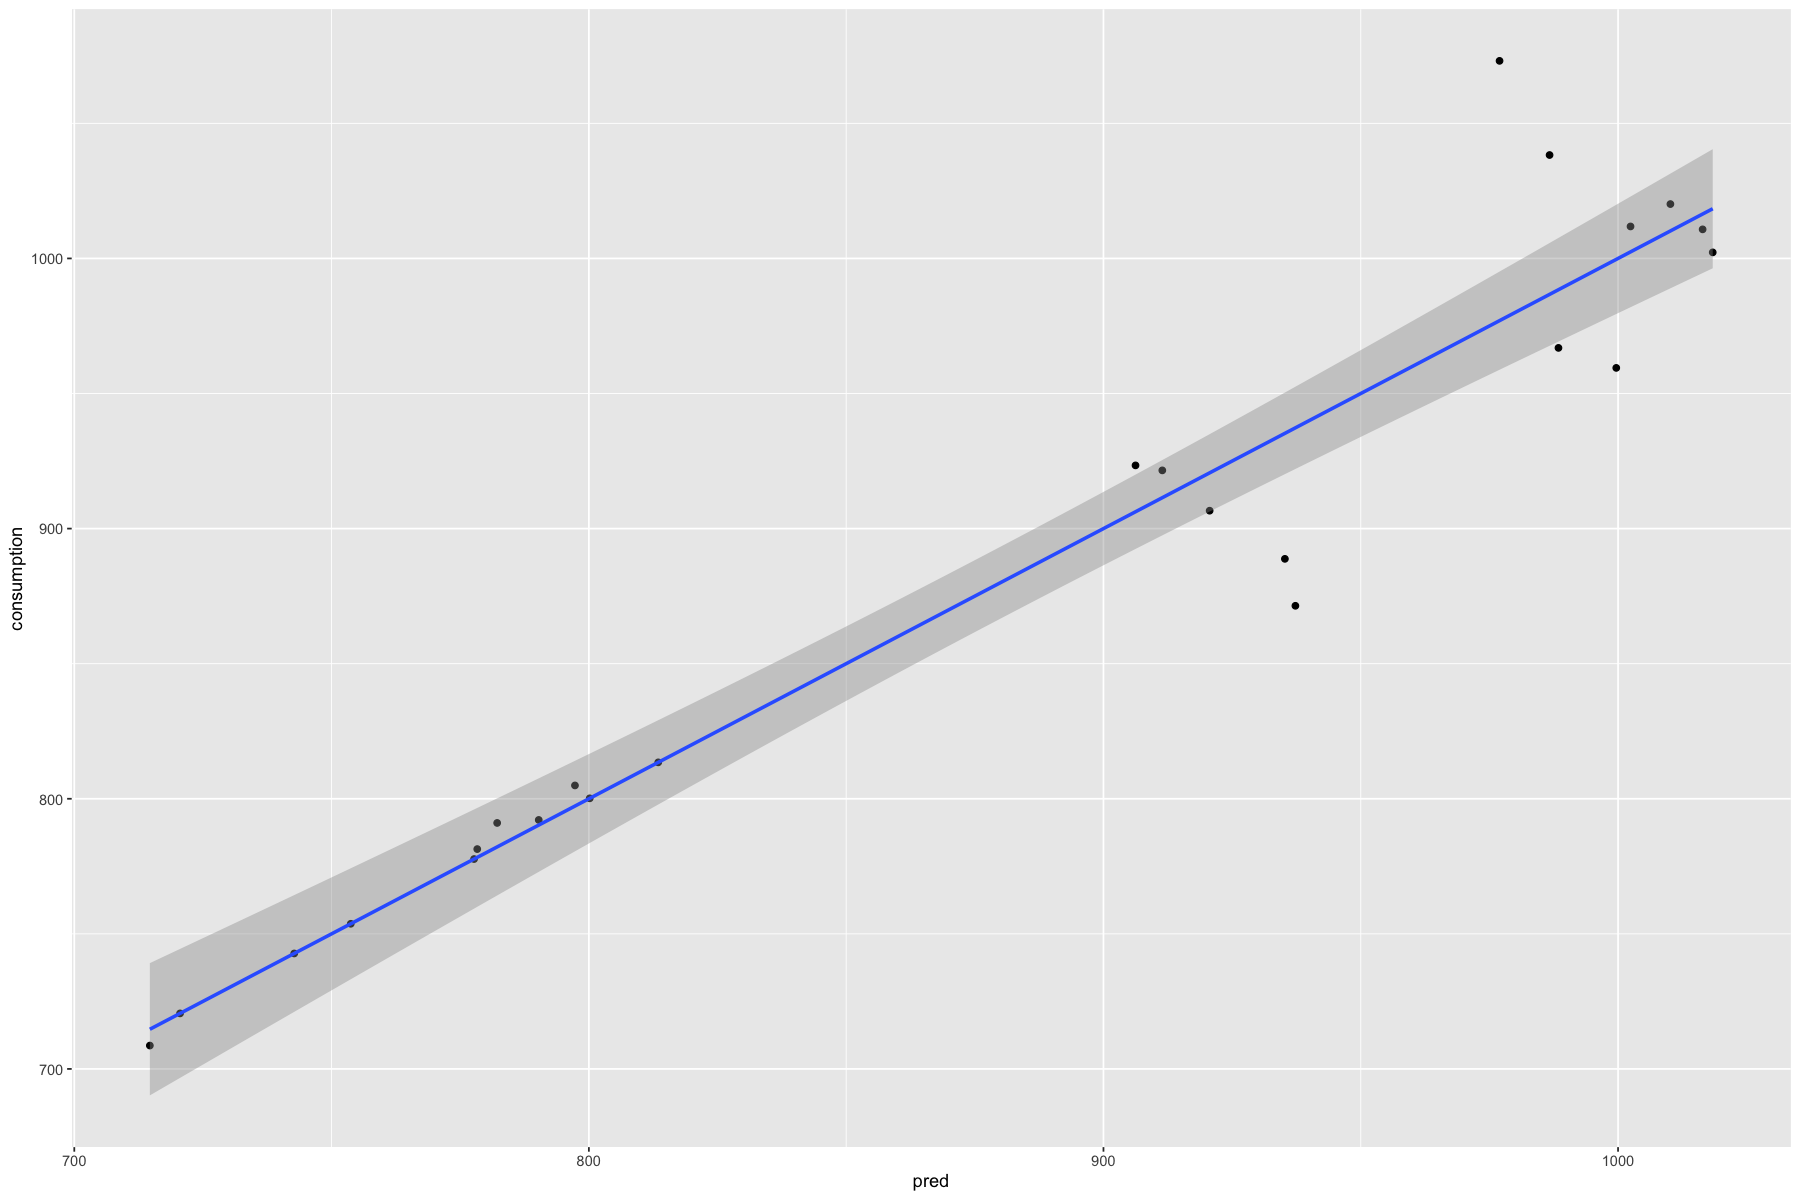

In [139]:
options(repr.plot.width = 15, repr.plot.height = 10)
ggplot(dfMonthly_pred, aes(x = pred, y = consumption)) +
    geom_point() +
    geom_smooth(method = "lm")